In [3]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.2 MB/s 


In [4]:
import pandas as pd
import numpy as np
import re
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Preprocessing + Feature Extraction

In [5]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)
# Text cleaning
#converting to lower case
dataset['comment_text_cleaned'] = dataset['comment_text'].str.lower()
#removing special characters
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(elem)))
#removing numbers
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
# Removing stop words
stop = stopwords.words('english')
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#Tokenizing
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_tokenize(x))
#Lemmitization
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_lemmatizer(x))
# Splitting into train test sets
X = dataset.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val,y_test_and_val, train_size=0.5)
train_tokens = pd.Series(X_train['comment_text_cleaned']).values
w2v_model = Word2Vec(train_tokens, size= 200)
def buildWordVector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in tokens:
    try:
      vec += w2v_model[word].reshape((1, size))
      count += 1.
    except KeyError:
      continue
  if count != 0:
    vec /= count
  return vec

train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in train_tokens])
train_vecs_w2v = scale(train_vecs_w2v)

val_tokens = pd.Series(X_val['comment_text_cleaned']).values
val_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in val_tokens])
val_vecs_w2v = scale(val_vecs_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# Learing curve (Ran for Naive Bayes too) 

In [ ]:
sizes, training_scores, testing_scores = learning_curve(ClassifierChain(LogisticRegression()), train_vecs_w2v, y_train, cv=10, scoring='f1_micro', train_sizes=np.linspace(0.01, 1.0, 50))

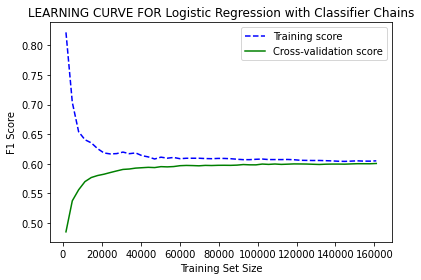

In [ ]:
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("LEARNING CURVE FOR Logistic Regression with Classifier Chains")
plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [6]:
sizes, training_scores, testing_scores = learning_curve(ClassifierChain(LogisticRegression()), train_vecs_w2v, y_train, cv=10, scoring='f1_micro', train_sizes=np.linspace(0.01, 1.0, 50))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

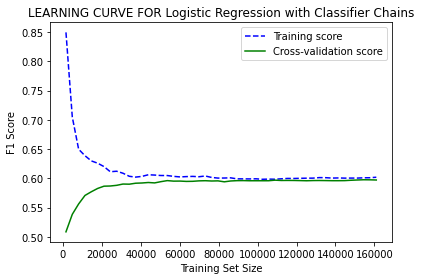

In [7]:
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("LEARNING CURVE FOR Logistic Regression with Classifier Chains")
plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Tuned random forest and its scores (Best parameters selected after generating score v/s value graph for each paramater) 

## (Also ran random forest with each Multi-Label Classification Technique) 

In [ ]:
forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 25, max_features = 'auto', max_depth = 12)
clf = ClassifierChain(forest)
clf.fit(train_vecs_w2v, y_train)
predictions = clf.predict(val_vecs_w2v) 
train_pred = clf.predict(train_vecs_w2v)

In [ ]:
def evaluation_metric(model_name, feature_extraction, y_true, y_pred):
  print('Model:', model_name)
  print('Feature extraction method:', feature_extraction)
  recall= recall_score(y_true, y_pred, average='micro')
  prec = precision_score(y_true, y_pred, average='micro')
  final_score = recall*0.6 + prec*0.4
  print('Precision: ', prec)
  print('Recall: ', recall)
  print('Final score of the model: ', final_score)
  return final_score

In [ ]:
result_test = evaluation_metric('Random Forest with Classifier Chains', 'Word2Vec', y_val, predictions)

Model: Random Forest with Classifier Chains
Feature extraction method: Word2Vec
Precision:  0.8018188707843881
Recall:  0.42379331063488884
Final score of the model:  0.5750035346946886


In [ ]:
result_train = evaluation_metric('Random Forest with Classifier Chains', 'Word2Vec', y_train, train_pred)

Model: Random Forest with Classifier Chains
Feature extraction method: Word2Vec
Precision:  0.9131631730050733
Recall:  0.5844786789508131
Final score of the model:  0.7159524765725171


In [ ]:
print("Variance is: ",result_train - result_test)

Variance is:  0.14094894187782858


## Class wise scores for Tuned Random Forest (Starting point of Error Analysis)

Model: Tuned Random Forest with Classifier Chains 
Feature extraction method: Word2Vec 

Results for label: toxic
Precision score: 0.8406445837063563
Recall score: 0.43899018232819076
Final Score: 0.599651942879457 

Results for label: severe_toxic
Precision score: 0.5833333333333334
Recall score: 0.03211009174311927
Final Score: 0.2525993883792049 

Results for label: obscene
Precision score: 0.8162450066577897
Recall score: 0.5082918739635157
Final Score: 0.6314731270412253 

Results for label: threat
Precision score: 0.75
Recall score: 0.039473684210526314
Final Score: 0.32368421052631585 

Results for label: insult
Precision score: 0.7353342428376535
Recall score: 0.47405452946350046
Final Score: 0.5785664148131616 

Results for label: identity_hate
Precision score: 0.6818181818181818
Recall score: 0.06912442396313365
Final Score: 0.3142019271051529 



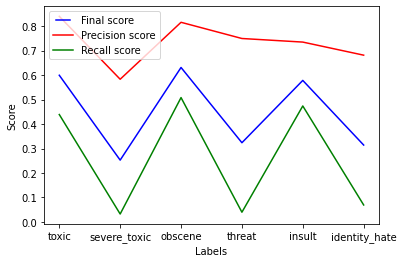

In [ ]:
def score(y_true, y_pred, label):
  prec = precision_score(y_true, y_pred)
  re = recall_score(y_true, y_pred)
  print('Results for label:', label)
  print('Precision score:', prec)
  print('Recall score:', re)
  print('Final Score:', re*0.6 + prec*0.4, '\n')
  return [re*0.6 + prec*0.4, prec, re]

# predictions = predictions.toarray()
# train_pred = train_pred.toarray()
y_pred = pd.DataFrame({'toxic': predictions[:, 0], 'severe_toxic': predictions[:, 1], 'obscene': predictions[:, 2], 'threat': predictions[:, 3], 'insult': predictions[:, 4], 'identity_hate': predictions[:, 5]})
y_pred_train = pd.DataFrame({'toxic': train_pred[:, 0], 'severe_toxic': train_pred[:, 1], 'obscene': train_pred[:, 2], 'threat': train_pred[:, 3], 'insult': train_pred[:, 4], 'identity_hate': train_pred[:, 5]})

print('Model: Tuned Random Forest with Classifier Chains \nFeature extraction method: Word2Vec ')
print()
prec_score = []
re_score = []
fina_score = []
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
  scores = score(y_val[label], y_pred[label], label)
  fina_score.append(scores[0])
  prec_score.append(scores[1])
  re_score.append(scores[2])

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(labels, fina_score, 'b', label='Final score')
line2, = plt.plot(labels, prec_score, 'r', label='Precision score')
line3, = plt.plot(labels, re_score, 'g', label='Recall score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('Labels')
plt.show()

Model: Tuned Random Forest with Classifier Chains 
Feature extraction method: Word2Vec 

Results for label: toxic
Precision score: 0.9388344988344989
Recall score: 0.5883487203459157
Final Score: 0.7285430317413489 

Results for label: severe_toxic
Precision score: 0.9724517906336089
Recall score: 0.22892347600518806
Final Score: 0.5263348018565563 

Results for label: obscene
Precision score: 0.9278232171043191
Recall score: 0.6637240812974748
Final Score: 0.7693637356202125 

Results for label: threat
Precision score: 0.9820359281437125
Recall score: 0.2965641952983725
Final Score: 0.5707528884365085 

Results for label: insult
Precision score: 0.8474984930681133
Recall score: 0.6204766107678729
Final Score: 0.711285363687969 

Results for label: identity_hate
Precision score: 0.9576719576719577
Recall score: 0.3173582700175336
Final Score: 0.5734837450793032 



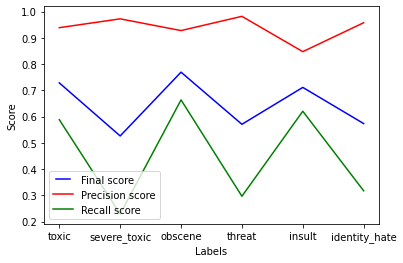

In [ ]:
print('Model: Tuned Random Forest with Classifier Chains \nFeature extraction method: Word2Vec ')
print()
prec_score = []
re_score = []
fina_score = []
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
  scores = score(y_train[label], y_pred_train[label], label)
  fina_score.append(scores[0])
  prec_score.append(scores[1])
  re_score.append(scores[2])

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(labels, fina_score, 'b', label='Final score')
line2, = plt.plot(labels, prec_score, 'r', label='Precision score')
line3, = plt.plot(labels, re_score, 'g', label='Recall score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('Labels')
plt.show()

## Saving the tuned RF

In [ ]:
import pickle
filename = 'tuned_random_forest_model.sav'
pickle.dump(clf, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

## Generating score v/s value graphs for max_depth parameter of RF (Ran for all of the hyperparameters of RF) 

Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.0
Recall:  0.0
Final score of the model:  0.0
Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.0
Recall:  0.0
Final score of the model:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.9132126543732025
Recall:  0.1358807833660575
Final score of the model:  0.44681353176891553
Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.9084791386271871
Recall:  0.13518926497095934
Final score of the model:  0.4445052144334505
Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.8726880948105584
Recall:  0.24467603081105574
Final score of the model:  0.49588085641085683
Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.8650176678445229
Recall:  0.24514320048067295
Final score of the model:  0.493092987426213
Model: Random Forest with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.8694386694386694
Recall:  0.3158133212505664
Final score of the model:  0.5372634605258076
Model: Random Forest with Multi Output Cl

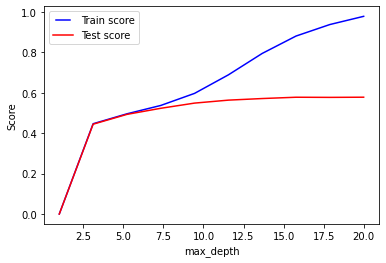

In [ ]:
solver = np.linspace(1, 20, 10, endpoint=True)
train_results = []
test_results = []
for estimator in solver:
   classifier = MultiOutputClassifier(RandomForestClassifier(max_depth = estimator))
   classifier.fit(train_vecs_w2v, y_train)
   train_pred = classifier.predict(train_vecs_w2v)
   score = evaluation_metric('Random Forest with Multi Output Classifier', 'Word2Vec', y_train, train_pred)
   train_results.append(score)

   y_pred = classifier.predict(val_vecs_w2v)
   score = evaluation_metric('Random Forest with Multi Output Classifier', 'Word2Vec', y_val, y_pred)
   test_results.append(score)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(solver, train_results, 'b', label='Train score')
line2, = plt.plot(solver, test_results, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('max_depth')
plt.show()